In [ ]:
import sys
from pathlib import Path

sys.path.insert(0, str(Path("..").resolve()))

from src.fx_data import load_fx_spot

Wide data: 13,835 trading days × 7 currencies
Date range: 1971-01-04 → 2026-02-20


In [17]:
df = load_fx_spot()

In [18]:
df.head()

date,currency,rate_per_usd
date,str,f64
1971-01-04,"""AUD""",0.898715
1971-01-04,"""CAD""",1.0109
1971-01-04,"""GBP""",0.417746
1971-01-04,"""JPY""",357.73
1971-01-05,"""AUD""",0.898311


In [ ]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import seaborn as sns

# ── Currency metadata ─────────────────────────────────────────────────────────
CURRENCIES = ["AUD", "BRL", "CAD", "GBP", "JPY", "MXN", "ZAR"]
CURRENCY_NAMES = {
    "AUD": "Australian Dollar",
    "BRL": "Brazilian Real",
    "CAD": "Canadian Dollar",
    "GBP": "British Pound",
    "JPY": "Japanese Yen",
    "MXN": "Mexican Peso",
    "ZAR": "South African Rand",
}

# ── colour palette ────────────────────────────────────────────────────────────
PALETTE = {
    "AUD": "#2563EB",  # Blue
    "BRL": "#16A34A",  # Green
    "CAD": "#D97706",  # Amber
    "GBP": "#7C3AED",  # Violet
    "JPY": "#DC2626",  # Red
    "MXN": "#EA580C",  # Orange
    "ZAR": "#0891B2",  # Cyan
}

# ── Matplotlib global style ───────────────────────────────────────────────────
plt.rcParams.update(
    {
        "figure.facecolor": "white",
        "axes.facecolor": "white",
        "axes.edgecolor": "#D1D5DB",
        "axes.linewidth": 0.8,
        "axes.grid": True,
        "grid.color": "#F3F4F6",
        "grid.linewidth": 0.8,
        "font.family": "sans-serif",
        "font.size": 11,
        "axes.titlesize": 13,
        "axes.titleweight": "bold",
        "axes.titlepad": 10,
        "axes.labelsize": 10,
        "axes.labelcolor": "#374151",
        "legend.fontsize": 10,
        "legend.framealpha": 0.95,
        "legend.edgecolor": "#E5E7EB",
        "xtick.color": "#6B7280",
        "ytick.color": "#6B7280",
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "figure.dpi": 120,
    }
)

# ── Shared data prep ──────────────────────────────────────────────────────────
_pdf = df.to_pandas()
_pdf["date"] = pd.to_datetime(_pdf["date"])
wide = _pdf.pivot(index="date", columns="currency", values="rate_per_usd").sort_index()
log_ret = np.log(wide / wide.shift(1))

# Macro stress periods shared across charts
SHADING = [
    ("2008-09-01", "2009-06-30", "GFC"),
    ("2020-02-15", "2020-06-30", "COVID-19"),
]

print(f"Wide data: {wide.shape[0]:,} trading days × {wide.shape[1]} currencies")
print(f"Date range: {wide.index[0].date()} → {wide.index[-1].date()}")


Wide data: 13,835 trading days × 7 currencies
Date range: 1971-01-04 → 2026-02-20


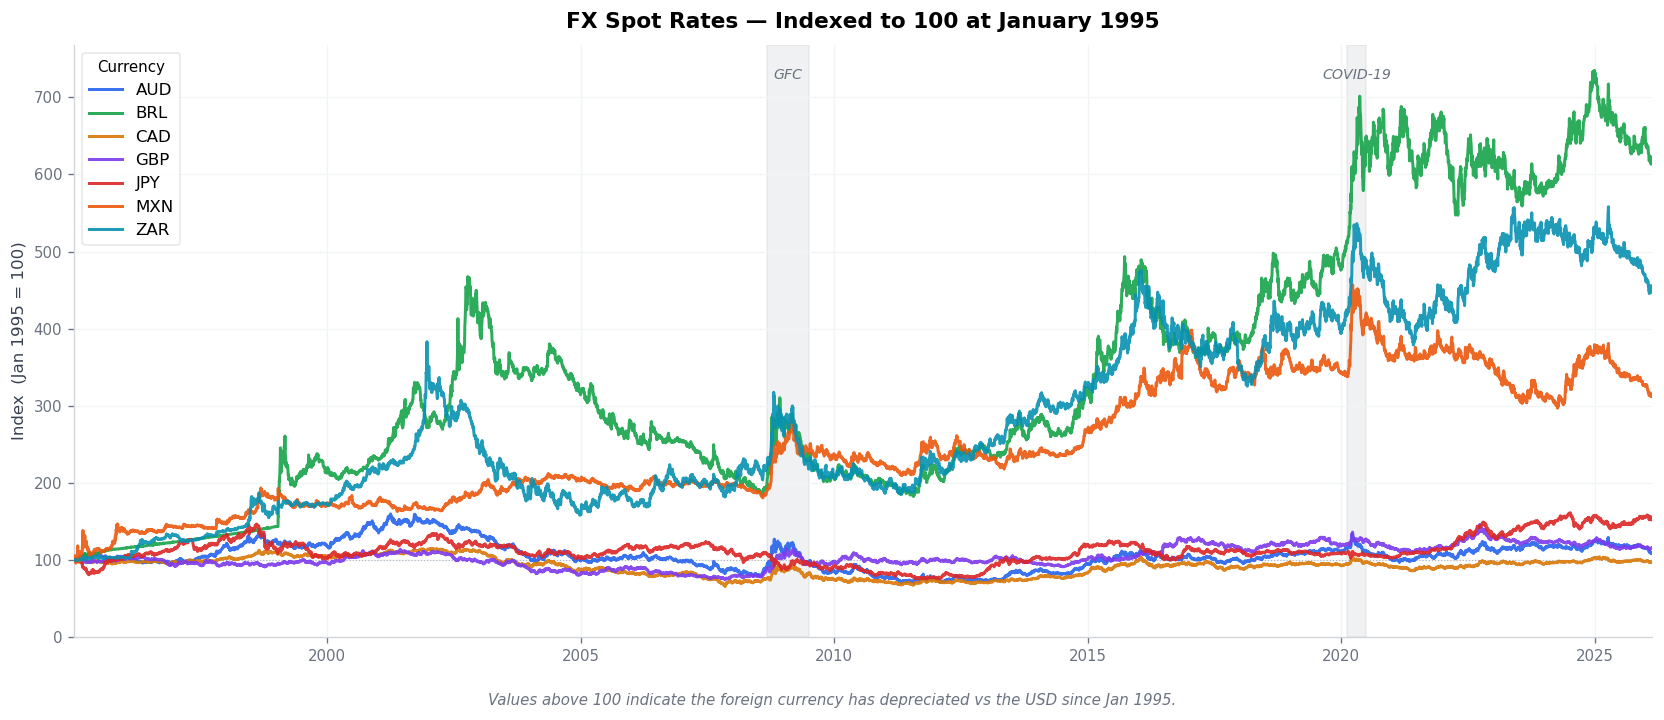

In [22]:
# ── Figure 1: Indexed Spot Rates (Jan 1995 = 100) ────────────────────────────
fig, ax = plt.subplots(figsize=(14, 6))

w = wide.loc["1995-01-01":]
base = w.bfill().iloc[0]
indexed = w.div(base) * 100

for ccy in CURRENCIES:
    series = indexed[ccy].dropna()
    ax.plot(
        series.index,
        series,
        color=PALETTE[ccy],
        linewidth=1.8,
        label=ccy,
        alpha=0.9,
        zorder=3,
    )

for start, end, label in SHADING:
    ax.axvspan(
        pd.Timestamp(start), pd.Timestamp(end), alpha=0.07, color="#374151", zorder=1
    )
    mid = pd.Timestamp(start) + (pd.Timestamp(end) - pd.Timestamp(start)) / 2
    ax.text(
        mid,
        0.96,
        label,
        transform=ax.get_xaxis_transform(),
        ha="center",
        va="top",
        fontsize=8.5,
        color="#6B7280",
        fontstyle="italic",
    )

ax.axhline(100, color="#9CA3AF", linewidth=0.7, linestyle=":", alpha=0.8)
ax.set_title("FX Spot Rates — Indexed to 100 at January 1995")
ax.set_ylabel("Index  (Jan 1995 = 100)")
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.set_xlim(indexed.index[0], indexed.index[-1])
ax.set_ylim(bottom=0)
ax.legend(loc="upper left", ncol=1, title="Currency", title_fontsize=9, frameon=True)

fig.text(
    0.5,
    0.01,
    "Values above 100 indicate the foreign currency has depreciated vs the USD since Jan 1995.",
    ha="center",
    fontsize=9,
    color="#6B7280",
    fontstyle="italic",
)
plt.tight_layout(rect=[0, 0.04, 1, 1])
plt.show()


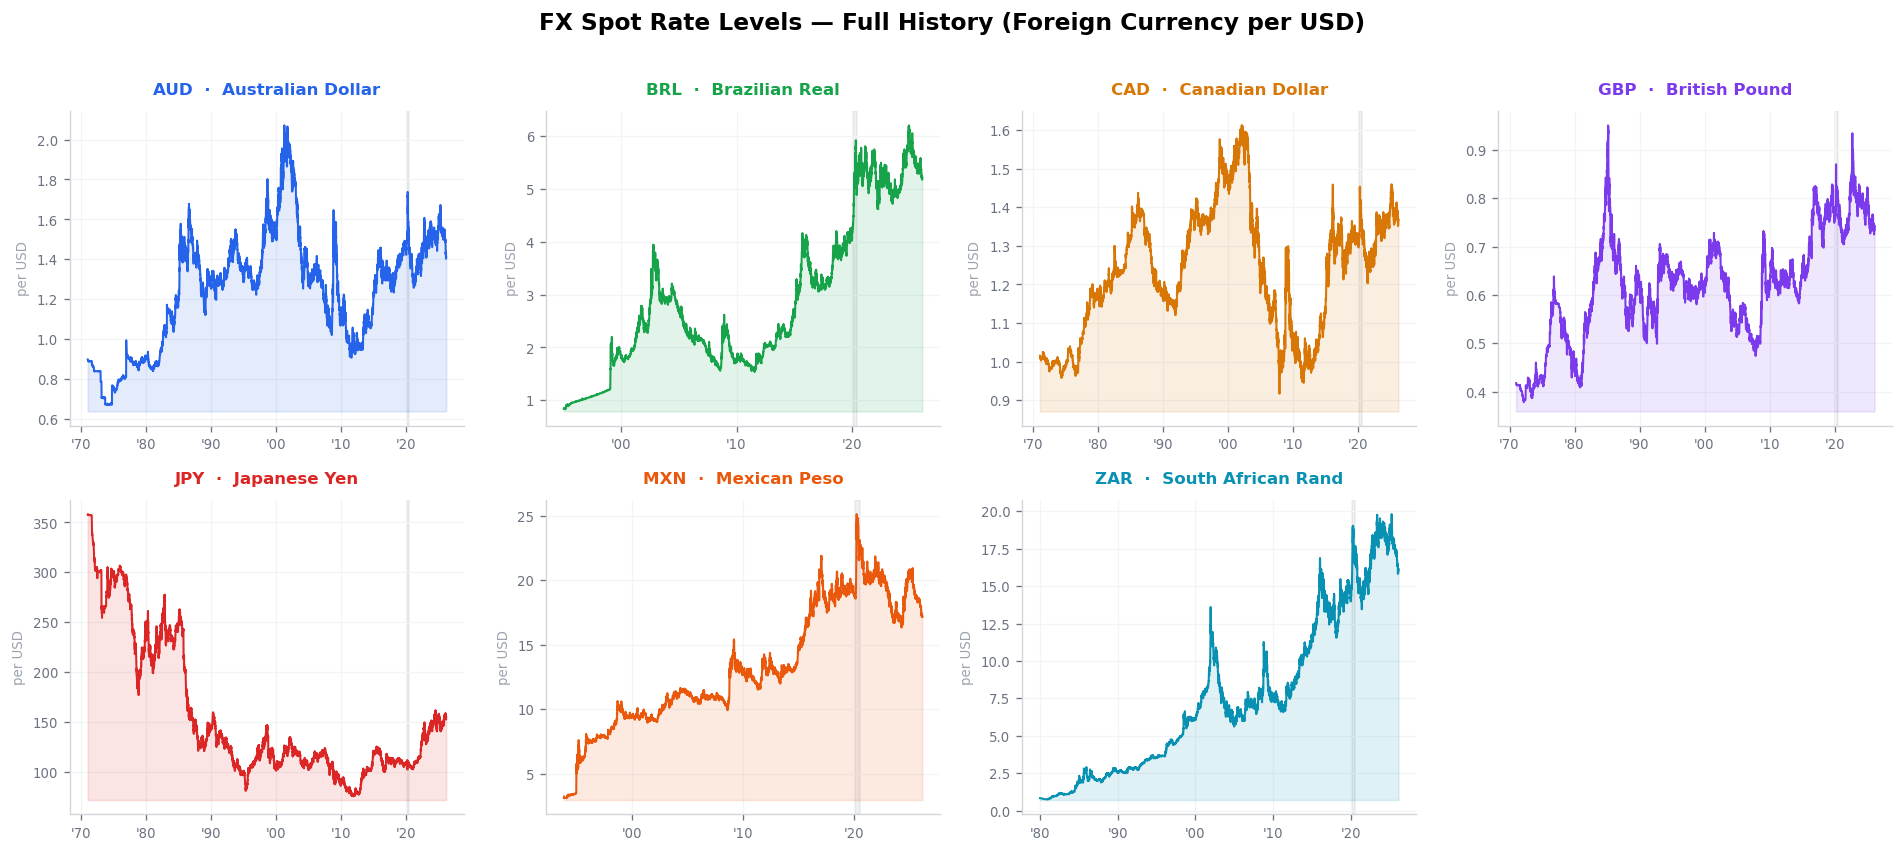

In [23]:
# ── Figure 2: Absolute Spot Rate Levels — Full History per Currency ────────────
fig, axes = plt.subplots(2, 4, figsize=(16, 7))
axes_flat = axes.flatten()

for i, ccy in enumerate(CURRENCIES):
    ax = axes_flat[i]
    series = wide[ccy].dropna()

    ax.plot(series.index, series, color=PALETTE[ccy], linewidth=1.2, zorder=3)
    ax.fill_between(
        series.index,
        series,
        series.min() * 0.95,
        color=PALETTE[ccy],
        alpha=0.12,
        zorder=2,
    )
    ax.axvspan(
        pd.Timestamp("2020-02-15"),
        pd.Timestamp("2020-06-30"),
        alpha=0.10,
        color="#6B7280",
        zorder=1,
    )
    ax.set_title(
        f"{ccy}  ·  {CURRENCY_NAMES[ccy]}",
        fontsize=10,
        fontweight="bold",
        color=PALETTE[ccy],
    )
    ax.set_ylabel("per USD", fontsize=8, color="#9CA3AF")
    ax.xaxis.set_major_locator(mdates.YearLocator(10))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("'%y"))
    ax.tick_params(labelsize=8)

axes_flat[-1].set_visible(False)

fig.suptitle(
    "FX Spot Rate Levels — Full History (Foreign Currency per USD)",
    fontsize=14,
    fontweight="bold",
    y=1.01,
)
plt.tight_layout()
plt.show()


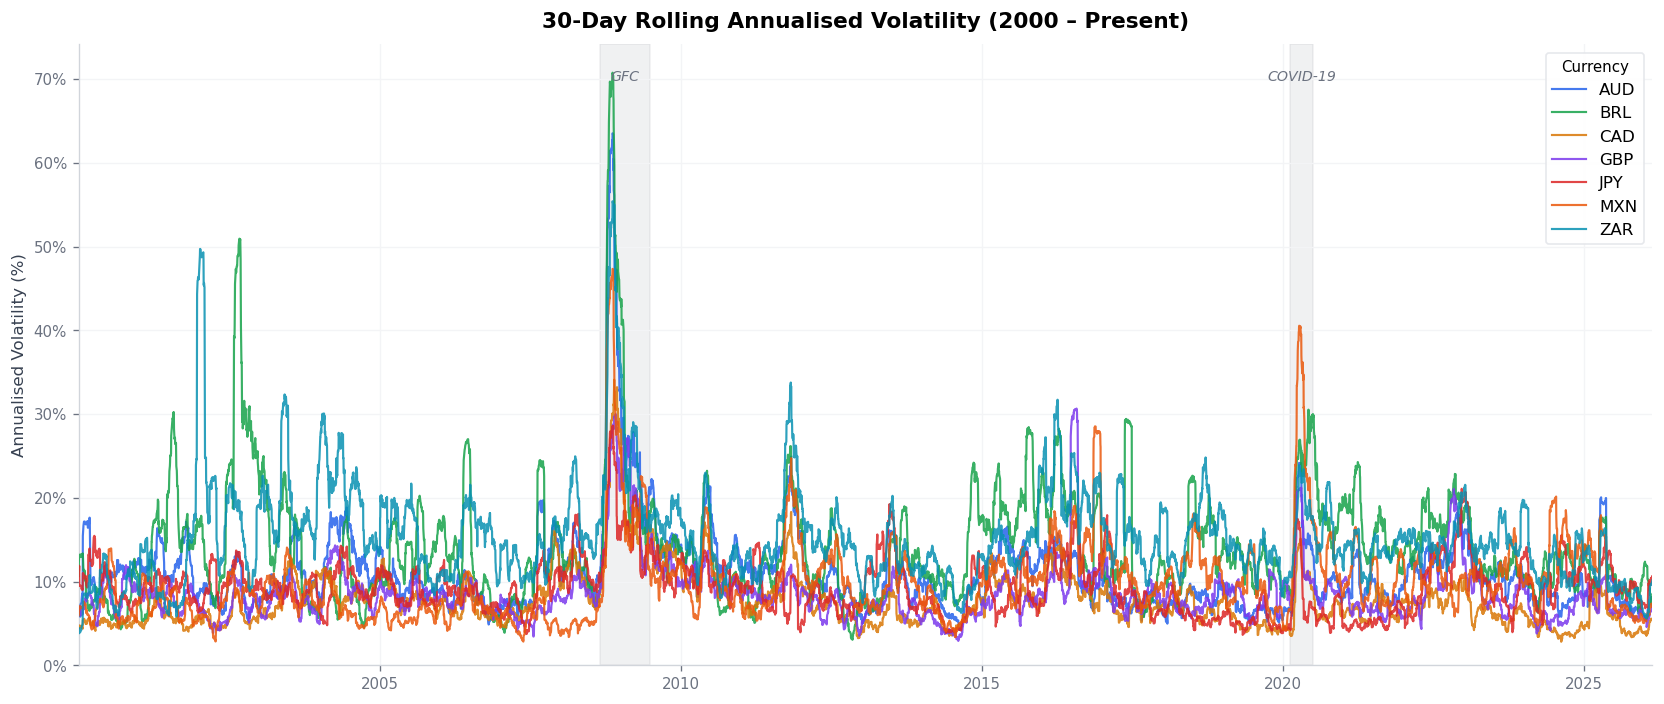

In [24]:
# ── Figure 3: 30-Day Rolling Annualised Volatility (2000–Present) ─────────────
vol = log_ret.rolling(30).std() * np.sqrt(252) * 100
vol = vol.loc["2000-01-01":]

fig, ax = plt.subplots(figsize=(14, 6))

for ccy in CURRENCIES:
    series = vol[ccy].dropna()
    ax.plot(
        series.index,
        series,
        color=PALETTE[ccy],
        linewidth=1.3,
        label=ccy,
        alpha=0.85,
        zorder=3,
    )

for start, end, label in SHADING:
    ax.axvspan(
        pd.Timestamp(start), pd.Timestamp(end), alpha=0.07, color="#374151", zorder=1
    )
    mid = pd.Timestamp(start) + (pd.Timestamp(end) - pd.Timestamp(start)) / 2
    ax.text(
        mid,
        0.96,
        label,
        transform=ax.get_xaxis_transform(),
        ha="center",
        va="top",
        fontsize=8.5,
        color="#6B7280",
        fontstyle="italic",
    )

ax.set_title("30-Day Rolling Annualised Volatility (2000 – Present)")
ax.set_ylabel("Annualised Volatility (%)")
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:.0f}%"))
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.set_xlim(vol.index[0], vol.index[-1])
ax.set_ylim(bottom=0)
ax.legend(loc="upper right", ncol=1, title="Currency", title_fontsize=9, frameon=True)

plt.tight_layout()
plt.show()


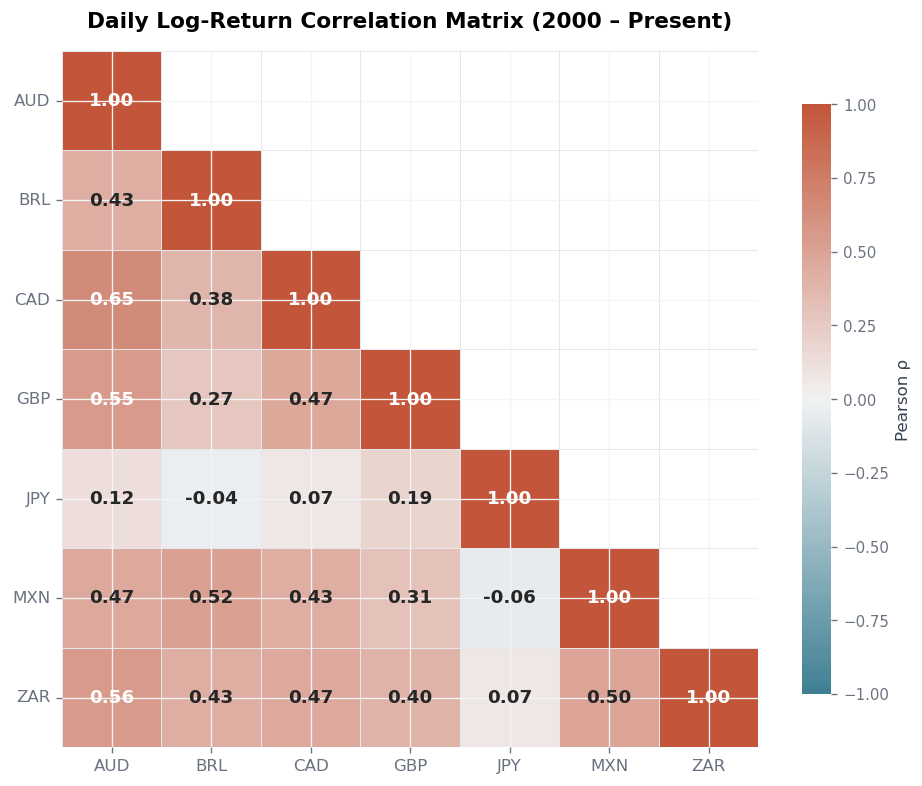

In [25]:
# ── Figure 4: Daily Log-Return Correlation Matrix (2000–Present) ──────────────
corr = log_ret.loc["2000-01-01":][CURRENCIES].corr()
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)  # hide upper triangle
cmap = sns.diverging_palette(220, 20, s=75, as_cmap=True)

fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    center=0,
    vmin=-1,
    vmax=1,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 11, "weight": "bold"},
    linewidths=0.6,
    linecolor="#E5E7EB",
    square=True,
    cbar_kws={"shrink": 0.75, "label": "Pearson ρ"},
    ax=ax,
)
ax.set_title("Daily Log-Return Correlation Matrix (2000 – Present)", pad=14)
ax.tick_params(axis="x", rotation=0, labelsize=10)
ax.tick_params(axis="y", rotation=0, labelsize=10)
ax.set_xlabel("")
ax.set_ylabel("")
plt.tight_layout()
plt.show()


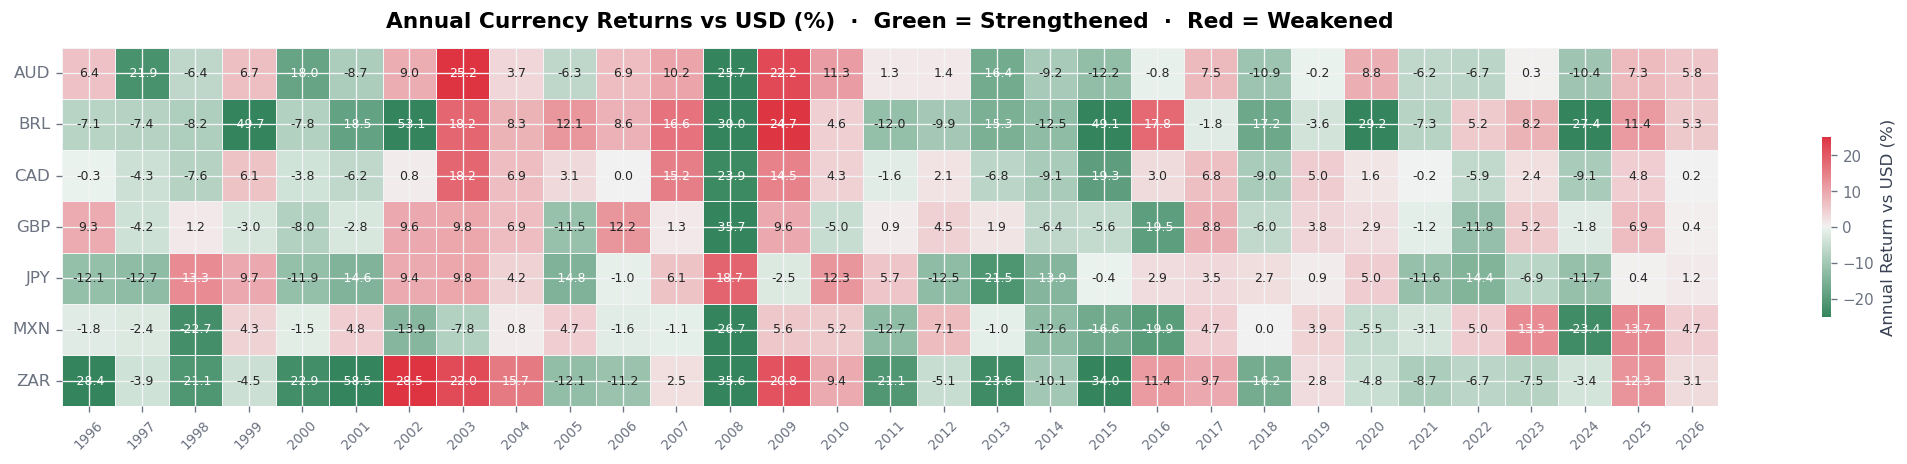

In [26]:
# ── Figure 5: Annual FX Returns vs USD — Calendar Heatmap ─────────────────────
annual = wide[CURRENCIES].resample("YE").last()
annual_ret = (-annual.pct_change() * 100).iloc[1:]  # flip: + = ccy strengthened
annual_ret.index = annual_ret.index.year
annual_ret = annual_ret.loc[1996:]  # drop first partial year

cmap = sns.diverging_palette(145, 10, s=80, as_cmap=True)  # green–white–red

fig, ax = plt.subplots(figsize=(18, 4))
sns.heatmap(
    annual_ret.T,  # currencies as rows, years as columns
    cmap=cmap,
    center=0,
    vmin=-25,
    vmax=25,
    annot=True,
    fmt=".1f",
    annot_kws={"size": 7.5},
    linewidths=0.4,
    linecolor="#F3F4F6",
    square=False,
    cbar_kws={"shrink": 0.5, "label": "Annual Return vs USD (%)"},
    ax=ax,
)
ax.set_title(
    "Annual Currency Returns vs USD (%)  ·  Green = Strengthened  ·  Red = Weakened",
    fontsize=13,
    fontweight="bold",
    pad=12,
)
ax.tick_params(axis="x", rotation=45, labelsize=8)
ax.tick_params(axis="y", rotation=0, labelsize=10)
ax.set_xlabel("")
ax.set_ylabel("")
plt.tight_layout()
plt.show()
